2025-05-21 17:49:58.227707: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747849798.419400      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747849798.474907      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CPUs available: 4
Total samples: 12162


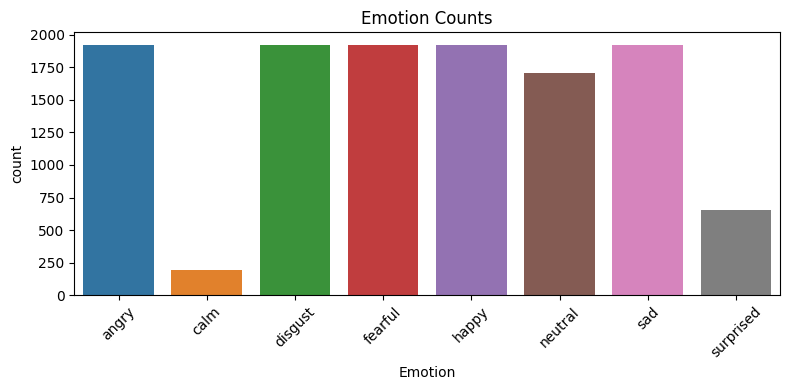

Feature extraction time: 516.2478834230001
Feature array shape: (60810, 4200)
Train / Val / Test shapes: (54729, 4200, 1) (3040, 4200, 1) (3041, 4200, 1)


I0000 00:00:1747850333.935083      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1747850344.115134     126 service.cc:148] XLA service 0x7f88f8019a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747850344.115740     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747850344.792986     126 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747850356.626774     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1 → loss: 1.2764, acc: 0.6328, val_loss: 1.1400, val_acc: 0.6832
Epoch 2 → loss: 1.0253, acc: 0.7434, val_loss: 1.1672, val_acc: 0.7066
Epoch 3 → loss: 0.9578, acc: 0.8071, val_loss: 1.1393, val_acc: 0.7510
Epoch 4 → loss: 0.9231, acc: 0.8547, val_loss: 1.0846, val_acc: 0.8128
Epoch 5 → loss: 0.9070, acc: 0.8901, val_loss: 1.2194, val_acc: 0.7891
Epoch 6 → loss: 0.9172, acc: 0.9059, val_loss: 1.2554, val_acc: 0.8049
Epoch 7 → loss: 0.8716, acc: 0.9255, val_loss: 1.2696, val_acc: 0.8003
Epoch 8 → loss: 0.6817, acc: 0.9707, val_loss: 0.8243, val_acc: 0.8849
Epoch 9 → loss: 0.5086, acc: 0.9838, val_loss: 0.8286, val_acc: 0.8602
Epoch 10 → loss: 0.5183, acc: 0.9686, val_loss: 0.8591, val_acc: 0.8595
Epoch 11 → loss: 0.4507, acc: 0.9805, val_loss: 0.8539, val_acc: 0.8553
Epoch 12 → loss: 0.3928, acc: 0.9895, val_loss: 0.6504, val_acc: 0.9013
Epoch 13 → loss: 0.3105, acc: 0.9980, val_loss: 0.5913, val_acc: 0.8980
Epoch 14 → loss: 0.2671, acc: 0.9961, val_loss: 0.6446, val_acc: 0.8813
E

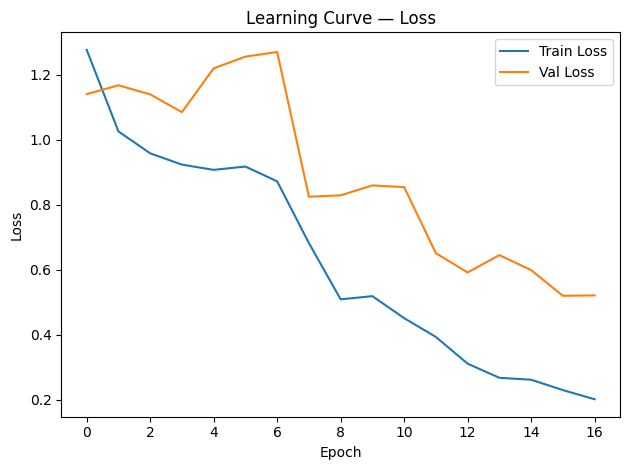

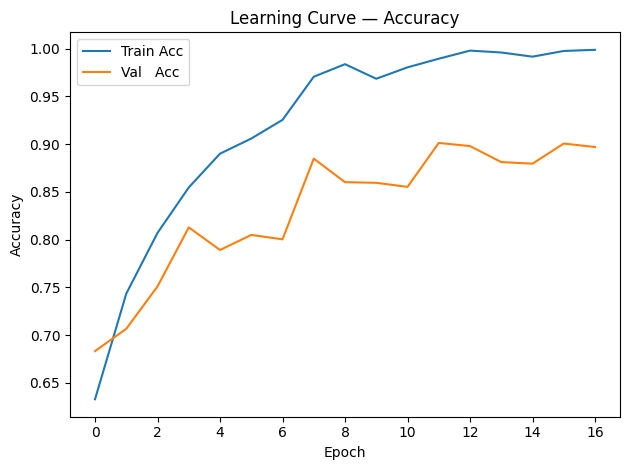

In [1]:
# Complete Speech Emotion Recognition Pipeline (Single Cell)
# No per‐epoch prints of loss/accuracy — training runs silently.

# 0. Setup & Imports
import os
import warnings
import timeit
import multiprocessing as mp
import numpy as np
import pandas as pd
import librosa, librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from joblib import Parallel, delayed
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout,
    Flatten, Dense
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
)

warnings.simplefilter("ignore")
print("CPUs available:", mp.cpu_count())

# 1. Paths to audio datasets
ravdess_path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
crema_path   = "/kaggle/input/cremad/AudioWAV/"
tess_path    = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
savee_path   = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# 2. Load & parse each dataset
def load_dataset(base_path, parser):
    records = []
    for entry in os.listdir(base_path):
        records.extend(parser(base_path, entry))
    return pd.DataFrame(records)

def parse_ravdess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        code = fname.split('-')[2]
        label = {
            '01':'neutral','02':'calm','03':'happy','04':'sad',
            '05':'angry','06':'fearful','07':'disgust','08':'surprised'
        }[code].lower()
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

ravdess_df = load_dataset(ravdess_path, parse_ravdess)

def parse_crema(base, fname):
    lab = fname.split('_')[2]
    label = {'SAD':'sad','ANG':'angry','DIS':'disgust',
             'FEA':'fearful','HAP':'happy','NEU':'neutral'}.get(lab, 'unknown').lower()
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

crema_df = load_dataset(crema_path, parse_crema)

def parse_tess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        lab = fname.split('_')[2].lower()
        label = 'surprised' if lab=='ps' else lab
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

tess_df = load_dataset(tess_path, parse_tess)

def parse_savee(base, fname):
    ele = fname.split('_')[1][:-6]
    label = {'a':'angry','d':'disgust','f':'fearful',
             'h':'happy','n':'neutral','sa':'sad'}.get(ele, 'surprised')
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

savee_df = load_dataset(savee_path, parse_savee)

# 3. Combine, clean & inspect
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], ignore_index=True)
data_path['Emotion'] = data_path['Emotion'].str.replace(r"\.wav$", "", regex=True)
data_path['Emotion'] = data_path['Emotion'].replace({
    'fear':'fearful','ps':'surprised','pleasantsurprise':'surprised'
})
data_path = shuffle(data_path, random_state=42).reset_index(drop=True)

print("Total samples:", len(data_path))
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=data_path, order=sorted(data_path.Emotion.unique()))
plt.title("Emotion Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Augmentation functions
def add_noise(x): return x + 0.035*np.random.uniform()*np.amax(x)*np.random.normal(size=x.shape)
def stretch(x, rate=0.8): return librosa.effects.time_stretch(y=x, rate=rate)
def shift(x): return np.roll(x, int(np.random.uniform(-5,5)*1000))
def pitch(x, sr, n_steps=0.7): return librosa.effects.pitch_shift(y=x, sr=sr, n_steps=n_steps)

# 5. Fixed-length feature extractor
n_mfcc, max_frames = 40, 100
def pad_truncate(feat, max_len):
    return (np.pad(feat, ((0,0),(0,max_len-feat.shape[1])), mode='constant')
            if feat.shape[1]<max_len else feat[:,:max_len])

def extract_features_fixed(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = pad_truncate(mfcc, max_frames)
    mfcc = (mfcc - mfcc.mean())/(mfcc.std()+1e-6)
    z = pad_truncate(librosa.feature.zero_crossing_rate(y=y), max_frames)
    r = pad_truncate(librosa.feature.rms(y=y), max_frames)
    stacked = np.vstack((mfcc, z, r))
    return stacked.flatten()

def get_features(path):
    y, sr = librosa.load(path, duration=2.5, offset=0.6)
    out = [extract_features_fixed(y, sr)]
    for fn in (add_noise, lambda x: stretch(x,0.8), shift, lambda x: pitch(x, sr, 0.7)):
        out.append(extract_features_fixed(fn(y), sr))
    return np.stack(out, axis=0)

# 6. Parallel feature computation
start = timeit.default_timer()
results = Parallel(n_jobs=-1)(delayed(get_features)(p) for p in data_path.Path)
print("Feature extraction time:", timeit.default_timer() - start)

# 7. Assemble X, Y
X, Y = [], []
for feats, emo in zip(results, data_path.Emotion):
    for vec in feats:
        X.append(vec)
        Y.append(emo)
X = np.vstack(X)
Y = np.array(Y)
print("Feature array shape:", X.shape)

# 8. Preprocess & split into Train/Val/Test (90/5/5)
scaler  = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
encoder = OneHotEncoder(sparse=False).fit(Y.reshape(-1,1))
Y_enc = encoder.transform(Y.reshape(-1,1))

# 8.1 → split off 90% train vs. 10% hold-out
x_train, x_hold, y_train, y_hold = train_test_split(
    X_scaled, Y_enc,
    test_size=0.10,
    random_state=42,
    stratify=np.argmax(Y_enc, axis=1)
)

# 8.2 → split hold-out 10% into 50/50 val & test (≈5% each)
x_val, x_test, y_val, y_test = train_test_split(
    x_hold, y_hold,
    test_size=0.50,
    random_state=42,
    stratify=np.argmax(y_hold, axis=1)
)

# reshape for Conv1D
x_tr_cnn  = x_train[..., np.newaxis]
x_val_cnn = x_val[...,   np.newaxis]
x_te_cnn  = x_test[...,  np.newaxis]
print("Train / Val / Test shapes:", x_tr_cnn.shape, x_val_cnn.shape, x_te_cnn.shape)

# 9. Epoch-detail logger callback
class EpochDetailLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        l = logs or {}
        print(f"Epoch {epoch+1} → loss: {l['loss']:.4f}, acc: {l['accuracy']:.4f}, "
              f"val_loss: {l['val_loss']:.4f}, val_acc: {l['val_accuracy']:.4f}")

# 10. Model & train (with higher Dropout rates)
from tensorflow.keras.regularizers import l2

# 10. Model & train (with L2 regularization instead of Dropout)
weight_decay = 1e-4

model = Sequential([
    Conv1D(
        512, 5,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay),
        input_shape=x_tr_cnn.shape[1:]
    ),
    BatchNormalization(),
    MaxPooling1D(5, 2, 'same'),

    Conv1D(
        512, 5,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),
    MaxPooling1D(5, 2, 'same'),

    Conv1D(
        256, 5,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),
    MaxPooling1D(5, 2, 'same'),

    Conv1D(
        256, 3,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),
    MaxPooling1D(5, 2, 'same'),

    Conv1D(
        128, 3,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),
    MaxPooling1D(3, 2, 'same'),

    Flatten(),

    Dense(
        512,
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),

    Dense(
        Y_enc.shape[1],
        activation='softmax',
        kernel_regularizer=l2(weight_decay)
    )
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3),
    EpochDetailLogger()
]

history = model.fit(
    x_tr_cnn, y_train,
    validation_data=(x_val_cnn, y_val),
    epochs=100, batch_size=64,
    callbacks=callbacks,
    verbose=0
)

# 11. Save training history
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# 12. Evaluate & report
train_loss, train_acc = model.evaluate(x_tr_cnn, y_train, verbose=0)
val_loss, val_acc     = model.evaluate(x_val_cnn, y_val, verbose=0)
best_model = load_model('best_model.keras')
test_loss, test_acc   = best_model.evaluate(x_te_cnn, y_test, verbose=0)

print(f"\nTrain Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

y_pred = np.argmax(best_model.predict(x_te_cnn, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.categories_[0]))

# 13. Visualize learning curves
with open('history.pkl', 'rb') as f:
    hist = pickle.load(f)

plt.figure()
plt.plot(hist['loss'],      label='Train Loss')
plt.plot(hist['val_loss'],  label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Learning Curve — Loss'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(hist['accuracy'],      label='Train Acc')
plt.plot(hist['val_accuracy'],  label='Val   Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Learning Curve — Accuracy'); plt.legend(); plt.tight_layout(); plt.show()


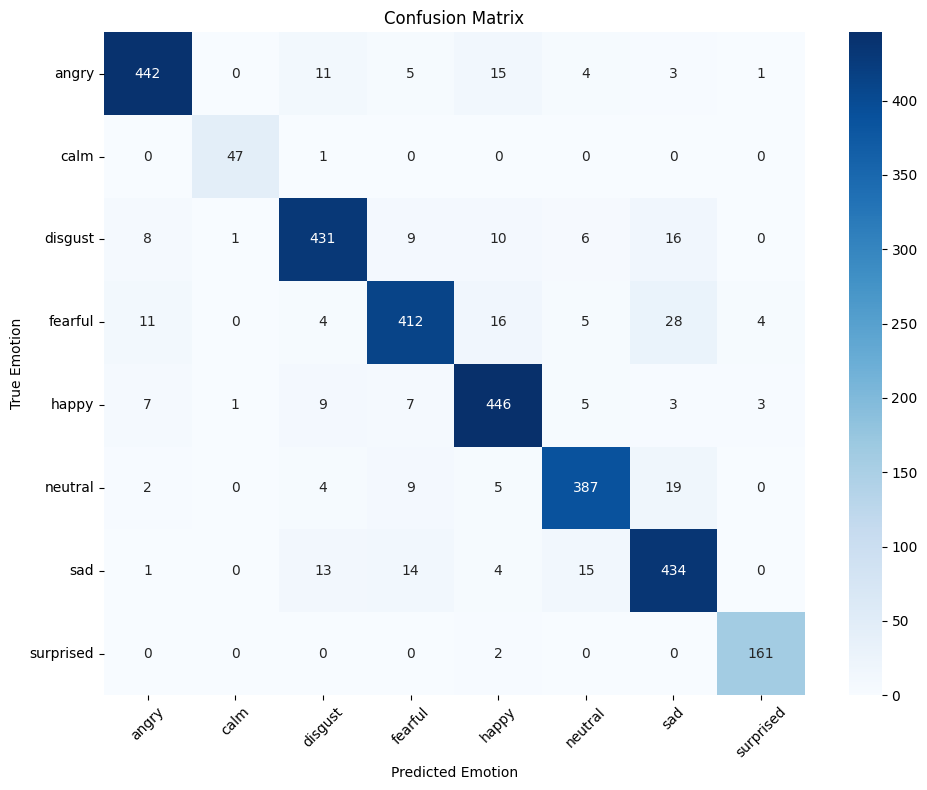

In [2]:

# 1. Build the confusion matrix array
cm = confusion_matrix(y_true, y_pred)
labels = encoder.categories_[0]

# 2. Plot it
plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,         # write the numbers in each cell
    fmt='d',            # integer format
    cmap='Blues',       # blue colour map
    xticklabels=labels, # predicted labels
    yticklabels=labels  # true labels
)
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


CPUs available: 4
Total samples: 12162


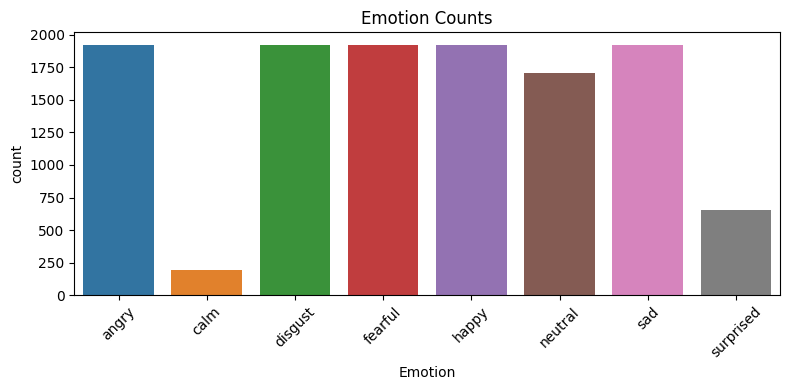

Feature extraction time: 484.3595761910001
Feature array shape: (60810, 4200)
Train / Val / Test shapes: (54729, 4200, 1) (3040, 4200, 1) (3041, 4200, 1)
Epoch 1 → loss: 1.2798, acc: 0.6320, val_loss: 1.1713, val_acc: 0.6645
Epoch 2 → loss: 1.0147, acc: 0.7436, val_loss: 1.0147, val_acc: 0.7533
Epoch 3 → loss: 0.9381, acc: 0.8091, val_loss: 1.0688, val_acc: 0.7862
Epoch 4 → loss: 0.9267, acc: 0.8572, val_loss: 1.1572, val_acc: 0.7951
Epoch 5 → loss: 0.8850, acc: 0.8922, val_loss: 1.3335, val_acc: 0.7694
Epoch 6 → loss: 1.0289, acc: 0.8821, val_loss: 1.2769, val_acc: 0.7974
Epoch 7 → loss: 0.8561, acc: 0.9247, val_loss: 1.2434, val_acc: 0.8072
Epoch 8 → loss: 0.8550, acc: 0.9279, val_loss: 1.3475, val_acc: 0.7839
Epoch 9 → loss: 0.8352, acc: 0.9344, val_loss: 1.2890, val_acc: 0.7941
Epoch 10 → loss: 0.7905, acc: 0.9401, val_loss: 1.1954, val_acc: 0.8329
Epoch 11 → loss: 0.7567, acc: 0.9487, val_loss: 1.2458, val_acc: 0.8118
Epoch 12 → loss: 0.7695, acc: 0.9417, val_loss: 1.2681, val_acc

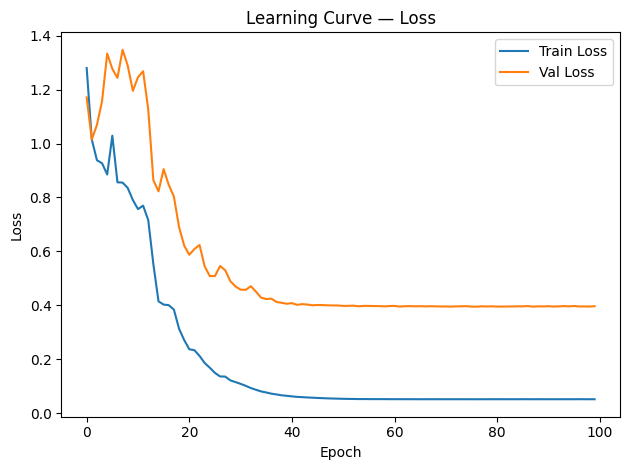

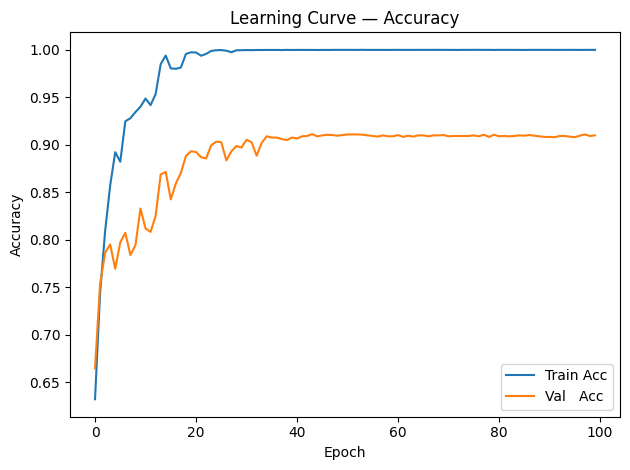

In [3]:
# Complete Speech Emotion Recognition Pipeline (Single Cell)
# No per‐epoch prints of loss/accuracy — training runs silently.

# 0. Setup & Imports
import os
import warnings
import timeit
import multiprocessing as mp
import numpy as np
import pandas as pd
import librosa, librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from joblib import Parallel, delayed
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout,
    Flatten, Dense
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
)

warnings.simplefilter("ignore")
print("CPUs available:", mp.cpu_count())

# 1. Paths to audio datasets
ravdess_path = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
crema_path   = "/kaggle/input/cremad/AudioWAV/"
tess_path    = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
savee_path   = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

# 2. Load & parse each dataset
def load_dataset(base_path, parser):
    records = []
    for entry in os.listdir(base_path):
        records.extend(parser(base_path, entry))
    return pd.DataFrame(records)

def parse_ravdess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        code = fname.split('-')[2]
        label = {
            '01':'neutral','02':'calm','03':'happy','04':'sad',
            '05':'angry','06':'fearful','07':'disgust','08':'surprised'
        }[code].lower()
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

ravdess_df = load_dataset(ravdess_path, parse_ravdess)

def parse_crema(base, fname):
    lab = fname.split('_')[2]
    label = {'SAD':'sad','ANG':'angry','DIS':'disgust',
             'FEA':'fearful','HAP':'happy','NEU':'neutral'}.get(lab, 'unknown').lower()
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

crema_df = load_dataset(crema_path, parse_crema)

def parse_tess(base, actor):
    recs = []
    dirpath = os.path.join(base, actor)
    for fname in os.listdir(dirpath):
        lab = fname.split('_')[2].lower()
        label = 'surprised' if lab=='ps' else lab
        recs.append({'Path': os.path.join(dirpath, fname), 'Emotion': label})
    return recs

tess_df = load_dataset(tess_path, parse_tess)

def parse_savee(base, fname):
    ele = fname.split('_')[1][:-6]
    label = {'a':'angry','d':'disgust','f':'fearful',
             'h':'happy','n':'neutral','sa':'sad'}.get(ele, 'surprised')
    return [{'Path': os.path.join(base, fname), 'Emotion': label}]

savee_df = load_dataset(savee_path, parse_savee)

# 3. Combine, clean & inspect
data_path = pd.concat([ravdess_df, crema_df, tess_df, savee_df], ignore_index=True)
data_path['Emotion'] = data_path['Emotion'].str.replace(r"\.wav$", "", regex=True)
data_path['Emotion'] = data_path['Emotion'].replace({
    'fear':'fearful','ps':'surprised','pleasantsurprise':'surprised'
})
data_path = shuffle(data_path, random_state=42).reset_index(drop=True)

print("Total samples:", len(data_path))
plt.figure(figsize=(8,4))
sns.countplot(x='Emotion', data=data_path, order=sorted(data_path.Emotion.unique()))
plt.title("Emotion Counts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Augmentation functions
def add_noise(x): return x + 0.035*np.random.uniform()*np.amax(x)*np.random.normal(size=x.shape)
def stretch(x, rate=0.8): return librosa.effects.time_stretch(y=x, rate=rate)
def shift(x): return np.roll(x, int(np.random.uniform(-5,5)*1000))
def pitch(x, sr, n_steps=0.7): return librosa.effects.pitch_shift(y=x, sr=sr, n_steps=n_steps)

# 5. Fixed-length feature extractor
n_mfcc, max_frames = 40, 100
def pad_truncate(feat, max_len):
    return (np.pad(feat, ((0,0),(0,max_len-feat.shape[1])), mode='constant')
            if feat.shape[1]<max_len else feat[:,:max_len])

def extract_features_fixed(y, sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = pad_truncate(mfcc, max_frames)
    mfcc = (mfcc - mfcc.mean())/(mfcc.std()+1e-6)
    z = pad_truncate(librosa.feature.zero_crossing_rate(y=y), max_frames)
    r = pad_truncate(librosa.feature.rms(y=y), max_frames)
    stacked = np.vstack((mfcc, z, r))
    return stacked.flatten()

def get_features(path):
    y, sr = librosa.load(path, duration=2.5, offset=0.6)
    out = [extract_features_fixed(y, sr)]
    for fn in (add_noise, lambda x: stretch(x,0.8), shift, lambda x: pitch(x, sr, 0.7)):
        out.append(extract_features_fixed(fn(y), sr))
    return np.stack(out, axis=0)

# 6. Parallel feature computation
start = timeit.default_timer()
results = Parallel(n_jobs=-1)(delayed(get_features)(p) for p in data_path.Path)
print("Feature extraction time:", timeit.default_timer() - start)

# 7. Assemble X, Y
X, Y = [], []
for feats, emo in zip(results, data_path.Emotion):
    for vec in feats:
        X.append(vec)
        Y.append(emo)
X = np.vstack(X)
Y = np.array(Y)
print("Feature array shape:", X.shape)

# 8. Preprocess & split into Train/Val/Test (90/5/5)
scaler  = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
encoder = OneHotEncoder(sparse=False).fit(Y.reshape(-1,1))
Y_enc = encoder.transform(Y.reshape(-1,1))

# 8.1 → split off 90% train vs. 10% hold-out
x_train, x_hold, y_train, y_hold = train_test_split(
    X_scaled, Y_enc,
    test_size=0.10,
    random_state=42,
    stratify=np.argmax(Y_enc, axis=1)
)

# 8.2 → split hold-out 10% into 50/50 val & test (≈5% each)
x_val, x_test, y_val, y_test = train_test_split(
    x_hold, y_hold,
    test_size=0.50,
    random_state=42,
    stratify=np.argmax(y_hold, axis=1)
)

# reshape for Conv1D
x_tr_cnn  = x_train[..., np.newaxis]
x_val_cnn = x_val[...,   np.newaxis]
x_te_cnn  = x_test[...,  np.newaxis]
print("Train / Val / Test shapes:", x_tr_cnn.shape, x_val_cnn.shape, x_te_cnn.shape)

# 9. Epoch-detail logger callback
class EpochDetailLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        l = logs or {}
        print(f"Epoch {epoch+1} → loss: {l['loss']:.4f}, acc: {l['accuracy']:.4f}, "
              f"val_loss: {l['val_loss']:.4f}, val_acc: {l['val_accuracy']:.4f}")

# 10. Model & train (with higher Dropout rates)
from tensorflow.keras.regularizers import l2

# 10. Model & train (with L2 regularization instead of Dropout)
weight_decay = 1e-4

model = Sequential([
    Conv1D(
        512, 5,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay),
        input_shape=x_tr_cnn.shape[1:]
    ),
    BatchNormalization(),
    MaxPooling1D(5, 2, 'same'),

    Conv1D(
        512, 5,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),
    MaxPooling1D(5, 2, 'same'),

    Conv1D(
        256, 5,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),
    MaxPooling1D(5, 2, 'same'),

    Conv1D(
        256, 3,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),
    MaxPooling1D(5, 2, 'same'),

    Conv1D(
        128, 3,
        padding='same',
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),
    MaxPooling1D(3, 2, 'same'),

    Flatten(),

    Dense(
        512,
        activation='relu',
        kernel_regularizer=l2(weight_decay)
    ),
    BatchNormalization(),

    Dense(
        Y_enc.shape[1],
        activation='softmax',
        kernel_regularizer=l2(weight_decay)
    )
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3),
    EpochDetailLogger()
]

history = model.fit(
    x_tr_cnn, y_train,
    validation_data=(x_val_cnn, y_val),
    epochs=100, batch_size=64,
    callbacks=callbacks,
    verbose=0
)

# 11. Save training history
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# 12. Evaluate & report
train_loss, train_acc = model.evaluate(x_tr_cnn, y_train, verbose=0)
val_loss, val_acc     = model.evaluate(x_val_cnn, y_val, verbose=0)
best_model = load_model('best_model.keras')
test_loss, test_acc   = best_model.evaluate(x_te_cnn, y_test, verbose=0)

print(f"\nTrain Accuracy:      {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy:       {test_acc:.4f}")

y_pred = np.argmax(best_model.predict(x_te_cnn, verbose=0), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.categories_[0]))

# 13. Visualize learning curves
with open('history.pkl', 'rb') as f:
    hist = pickle.load(f)

plt.figure()
plt.plot(hist['loss'],      label='Train Loss')
plt.plot(hist['val_loss'],  label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Learning Curve — Loss'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(hist['accuracy'],      label='Train Acc')
plt.plot(hist['val_accuracy'],  label='Val   Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Learning Curve — Accuracy'); plt.legend(); plt.tight_layout(); plt.show()


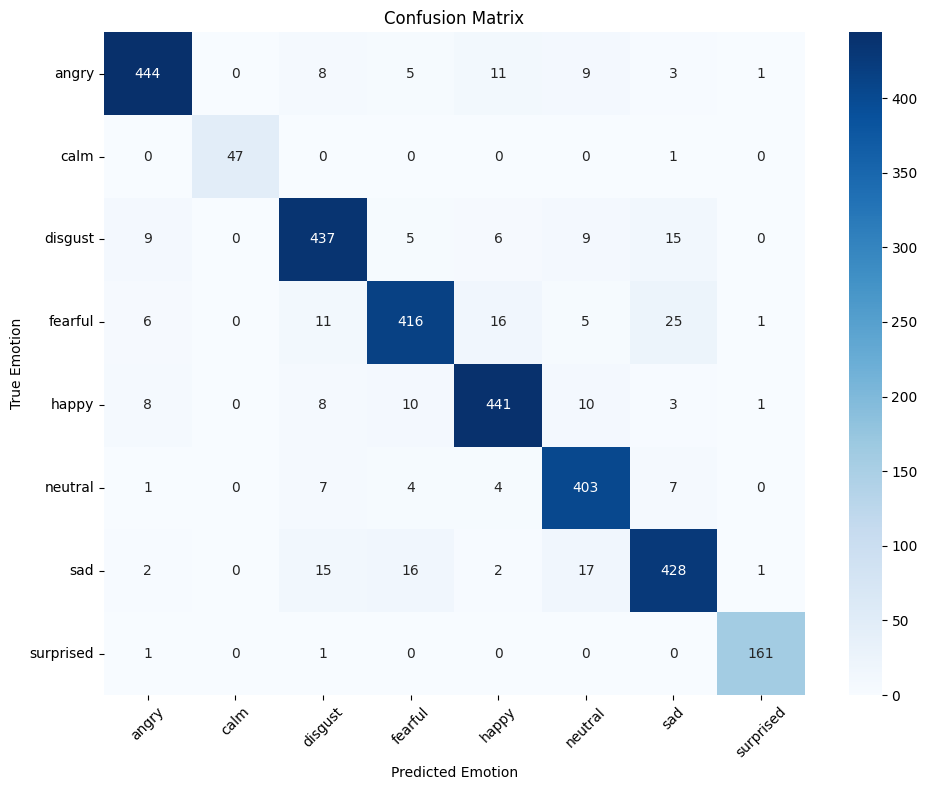

In [4]:

# 1. Build the confusion matrix array
cm = confusion_matrix(y_true, y_pred)
labels = encoder.categories_[0]

# 2. Plot it
plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,         # write the numbers in each cell
    fmt='d',            # integer format
    cmap='Blues',       # blue colour map
    xticklabels=labels, # predicted labels
    yticklabels=labels  # true labels
)
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
